## Import necessary libraries

In [1]:
import sys
sys.path.append("../vessel_model_tuning_lib/")
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')


w_plot = 12
h_plot = w_plot / 1.85

mpl.rcParams['figure.figsize'] = (w_plot, h_plot)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import ship_dimensions
import mmg_model_parameters
import resistance_parameters
import seakeeping
import vessel_model_common
import propeller

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

## Print overview of the tuning library

In [2]:
help(resistance_parameters)

Help on module resistance_parameters:

NAME
    resistance_parameters

DESCRIPTION
    Implementation of various empirical models for straight ahead resistance 
    components.

FUNCTIONS
    CF_ITTC(ship_dim, U)
        Frictional resistance coefficient from the ITTC
    
    CR_wave_polynomial(Fr, m, p)
        Simplified polynomial model for the wave resistance
    
    default_wave_resistance(ship_dim, U)
        Default model chosen based on which model that gives the "most 
        reasonable" value for mA2
    
    fit_wave_polynomial(Fr, CR)
        Function that fits wave resistance data to a polynomial model
    
    hollenbach_wave_resistance(ship_dim, U)
        Calculates the wave resistance according to the Hollenbach 98 empirical model:
        Hollenbach et. al (1998): "Estimating Resistance and Propulsion for 
        Single-Screw and Twin-Screw Ships"
        
        The implementaiton has neglected all terms related to rudder and propeller 
        geoemtry, and ass

In [3]:
help(mmg_model_parameters)

Help on module mmg_model_parameters:

NAME
    mmg_model_parameters

DESCRIPTION
    Implementation of various empirical equations for the model coefficients in the 
    MMG model.
    
    A good overview of different empirical equations suitable for the MMG model is 
    given in: "Theoretical background and application of MANSIM for ship 
    maneuvering simulations"
    
    The following references from this overview paper is currently implemented:
    
    - Lee et. al (1998): "The prediction of ship's manoeuvring performance in the 
      initial design stage"
    - Yoshimura et. al (2012): "Hydrodynamic database and manoeuvring prediction 
      method with medium high-speed merchant ships and fishing vessels"
    
    In addition, there is a function that returns experimentally adjusted values for 
    the tanker ship KVLCC2
    
    The equations from the different papers are implemented in seperate functions. 
    The results from the functions are store in a dictionary with

## Ship data structure

The code below sets and stores the main dimensions of the ship in an object that can be used as input to the functions in the library. The wetted surface is calculated empirically

In [4]:
ship_name = 'Zeabuz 1'

L = 12
B = 5
T = 0.91
rho = 1025.9
g = 9.81
mass = 16116.7
volume = mass / rho

ship_dim = ship_dimensions.ShipDimensions(L, B, T, volume)

print('Wetted surface:   ', np.round(ship_dim.S, 1), 'm^2')
print('Block coefficient:', np.round(ship_dim.CB, 4))

Wetted surface:    45.2 m^2
Block coefficient: 0.2877


## Straight ahead resistance

### Models

In [5]:
class NewResistance():
    ''' 
    Class that implements the new resistance model (same as the FMU implementation),
    for easy ploting.
    '''
    
    def __init__(self, ship_dim):
        self.ship_dim = ship_dim
        self.k = 0.0
        self.Cbd_factor = 0.0
        self.CR_m = 0.0
        self.CR_p = 0.0
        
    def resistance(self, u):
        Fr = u / np.sqrt(ship_dim.L * ship_dim.g)
        
        CF = resistance_parameters.CF_ITTC(ship_dim, u)
        
        CR = resistance_parameters.CR_wave_polynomial(Fr, self.CR_m, self.CR_p)
        
        Cbd = self.Cbd_factor * (self.ship_dim.T * self.ship_dim.B / self.ship_dim.S)**1.5 / np.sqrt(CF)
        
        CT = CF * (1 + self.k) + CR + Cbd
        
        return CT * 0.5 * ship_dim.rho * ship_dim.S * u**2
        

In [6]:
class OldResistance():
    ''' Class that implements the old straight ahead resistance model for mA2, for comparison'''
    
    def __init__(self):
        self.X_u   = 238.55
        self.X_uu  = 37.1570
        self.X_uuu = 50
        
    def resistance(self, u):
        return self.X_u * u + self.X_uu * u**2 + self.X_uuu * u**3

### Estimate paramaters for straight ahead resistance

Shape factor, k =  0.0582
Wave resistance, CR(Fr) = 0.44864 Fr^4.762


(0.0, 0.007157105667527044)

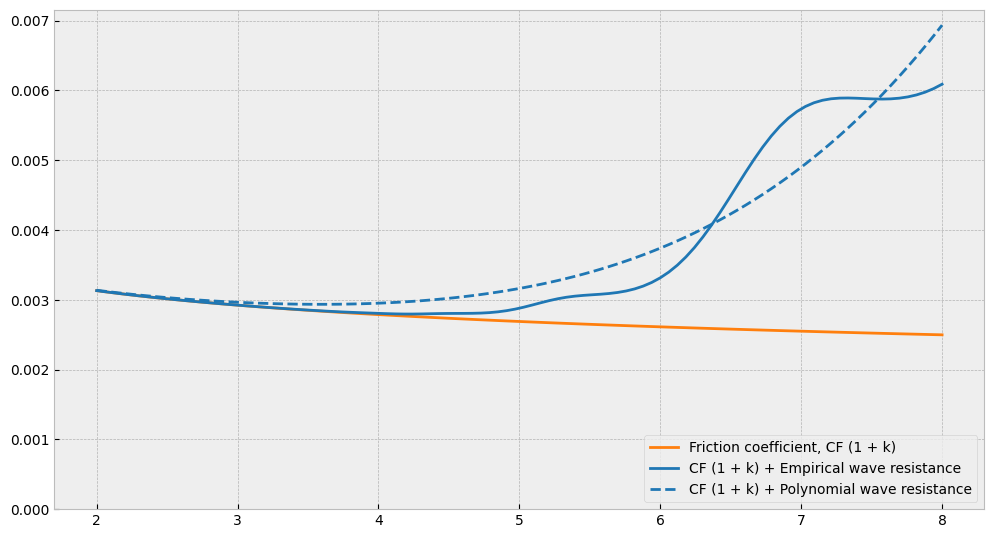

In [7]:
n = 100

U_knots = np.linspace(2, 8, n)
U = U_knots * 0.51444444444

Fr = U / np.sqrt(ship_dim.L * ship_dim.g)

CR = np.zeros(n)
CF = np.zeros(n)

k = resistance_parameters.marintek_shape_factor(ship_dim)

print('Shape factor, k = ', np.round(k, 4))

for i in range(n):
    CR[i] = resistance_parameters.default_wave_resistance(ship_dim, U[i])
    CF[i] = resistance_parameters.CF_ITTC(ship_dim, U[i]) * (1 + k)
    
popt_CR = resistance_parameters.fit_wave_polynomial(Fr, CR)

print('Wave resistance, CR(Fr) = {:.5f} Fr^{:.3f}'.format(popt_CR[0], popt_CR[1]))

CR_model = resistance_parameters.CR_wave_polynomial(Fr, *popt_CR)

CT = CF + CR


plt.plot(U_knots, CF, label='Friction coefficient, CF (1 + k)', color=tableau20[2])
    
plt.plot(U_knots, CF + CR, label='CF (1 + k) + Empirical wave resistance', color=tableau20[0])
plt.plot(U_knots, CF + CR_model, '--', label='CF (1 + k) + Polynomial wave resistance', color=tableau20[0])

plt.legend(loc=4)

plt.ylim(0.0, None)

### Compare old and new model

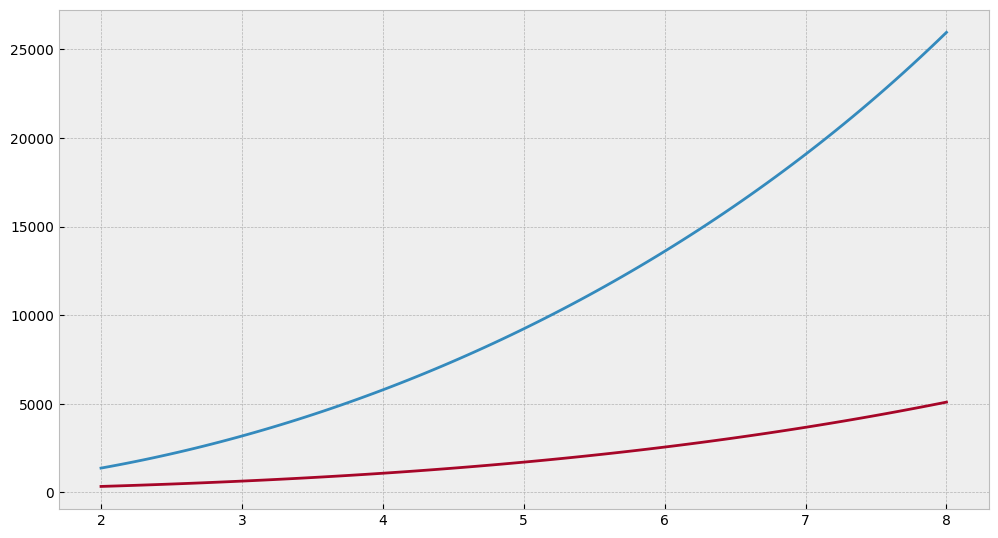

In [8]:
model_new = NewResistance(ship_dim)

model_new.k          = k
model_new.CR_m       = popt_CR[0]
model_new.CR_p       = popt_CR[1]
model_new.Cbd_factor = 0.09 # Tuned to make the old and new model fit at low speeds.   


model_old = OldResistance()

r_new = np.zeros(n)
r_old = np.zeros(n)

for i in range(n):
    r_new[i] = model_new.resistance(U[i])
    r_old[i] = model_old.resistance(U[i])
    
plt.plot(U_knots, r_new)
plt.plot(U_knots, r_old)

## Maneuvering model

### Default coefficients

In [9]:
coeffs = mmg_model_parameters.default_coefficients(ship_dim)

### Stabilize model

The mass of the ship affects the stability of the model. The empirical tuning library are found to give models that generally become very unstable for vessels such as mA2. This is not necessarily physically correct; the viscous damping will generally be larger for small ships than large ships, relative to the main dimensions. The tuning library have a helper function that adjust the yaw moment coefficients to ensure stability at a given speed (in general, the higher the forward speed, the more stable will the ship be) 

In [10]:
U_stable = 2.5 * 0.5144444444 # Speed where the model is forced to be stable

# Adjust the default coefficients
coeffs = mmg_model_parameters.stabilize_coefficients(ship_dim, coeffs, U_stable, x_cp = 0.25)

#### Checkt the stability

In [11]:
def check_linear_stability(ship_dim, coeffs, U):
    '''Function that calculates the linear stability of the models'''
    
    M_prime = ship_dim.mass / (0.5 * ship_dim.rho * ship_dim.T * ship_dim.L * U**2)
    
    Ir = coeffs['Nr'] / (coeffs['Yr'] - M_prime)
    Iv = coeffs['Nv'] / coeffs['Yv']
    
    return Ir - Iv

Text(0, 0.5, 'Ir - Iv (stable when value > 0.0)')

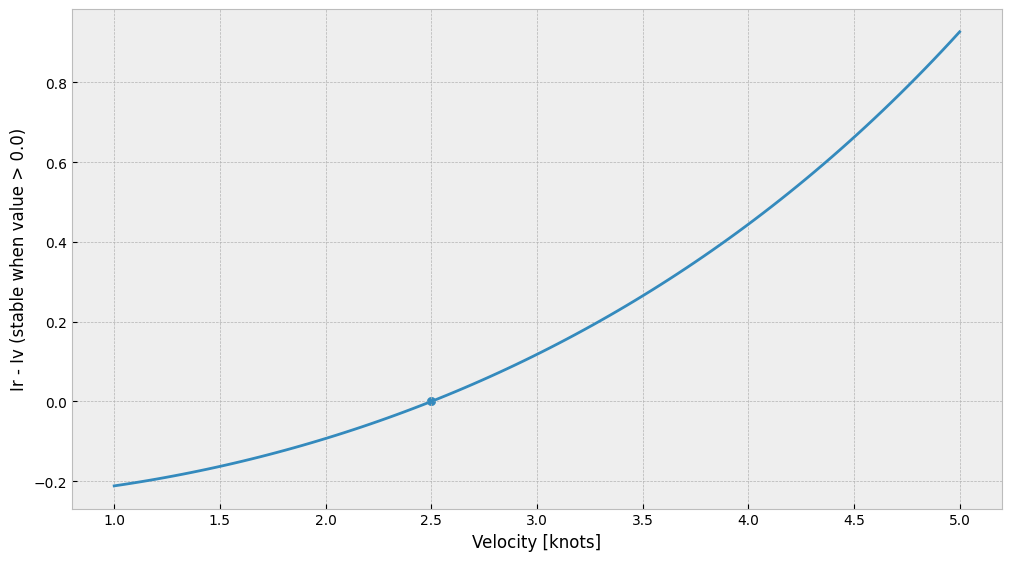

In [12]:
n_test = 100
U_test = np.linspace(1, 5, n_test) * 0.5144444444

stability = np.zeros(n_test)

for i in range(n_test):
    stability[i] = check_linear_stability(ship_dim, coeffs, U_test[i])
    
plt.plot(U_test / 0.51444444, stability)

plt.scatter(U_stable / 0.51444444, 0.0)

plt.xlabel('Velocity [knots]')
plt.ylabel('Ir - Iv (stable when value > 0.0)')

### Write paramaters to disk, to ease copying into osp setup files

In [13]:
vessel_model_common.write_osp_coeffs_to_xml(coeffs, ship_name + '_maneuvering_coeffs.xml')

coeffs

{'mx': 1478.773296,
 'my': 14989.383864000001,
 'Jz': 106471.677312,
 'Xvv': -0.04,
 'Xvr': 0.002,
 'Xrr': 0.011,
 'Xvvvv': 0.771,
 'Yv': -0.315,
 'Yr': 0.083,
 'Yvvv': -1.607,
 'Yvrr': -0.391,
 'Yvvr': 0.379,
 'Yrrr': 0.008,
 'Nv': -0.07875,
 'Nr': -0.4141220319464219,
 'Nvvv': -0.03,
 'Nvrr': 0.055,
 'Nvvr': -0.294,
 'Nrrr': -0.013}

## Plot variables

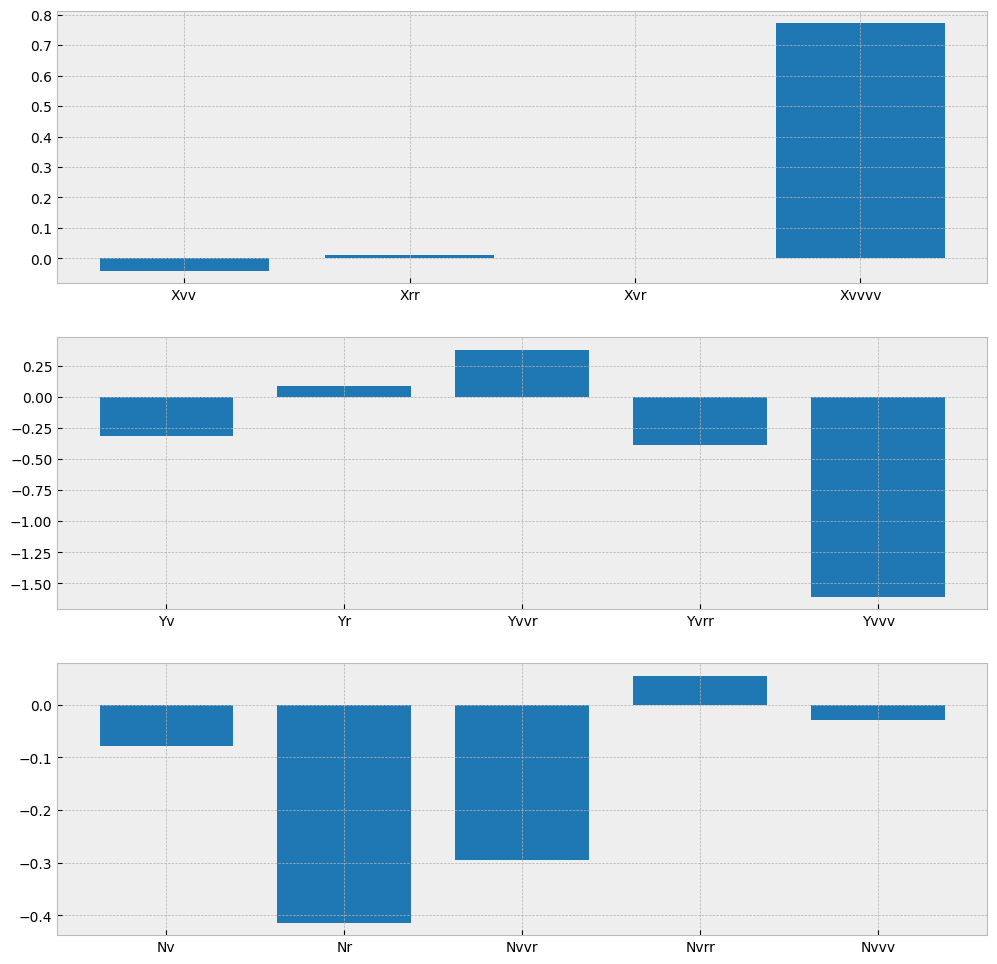

In [14]:
fig = plt.figure(figsize=(w_plot, w_plot))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax_list = [ax1, ax2, ax3]

for i_a in range(3):
    ax = ax_list[i_a]
    plt.sca(ax)
    
    if i_a == 0:
        keys = ["Xvv", "Xrr", "Xvr", "Xvvvv"]
    elif i_a == 1:
        keys = ["Yv", "Yr", "Yvvr", "Yvrr", "Yvvv"]
    elif i_a == 2:
        keys = ["Nv", "Nr", "Nvvr", "Nvrr", "Nvvv"]

    n = len(keys)

    x0 = np.linspace(1, n, n)

    width = 0.75
    model_space = 0.025

    color=[tableau20[0], tableau20[4]]

    for i in range(len(keys)):
        key = keys[i]

        x = x0[i]

        height = coeffs[key]

        plt.bar(x, height, width=width, color=color)

    plt.xticks(x0);
    
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = keys

    ax.set_xticklabels(labels)

# Seakeeping model

Heave: Natural period:  1.96s, damping ratio: 0.3
Roll: Natural period:  2.29s, damping ratio: 0.15
Pitch: Natural period:  1.80s, damping ratio: 0.3


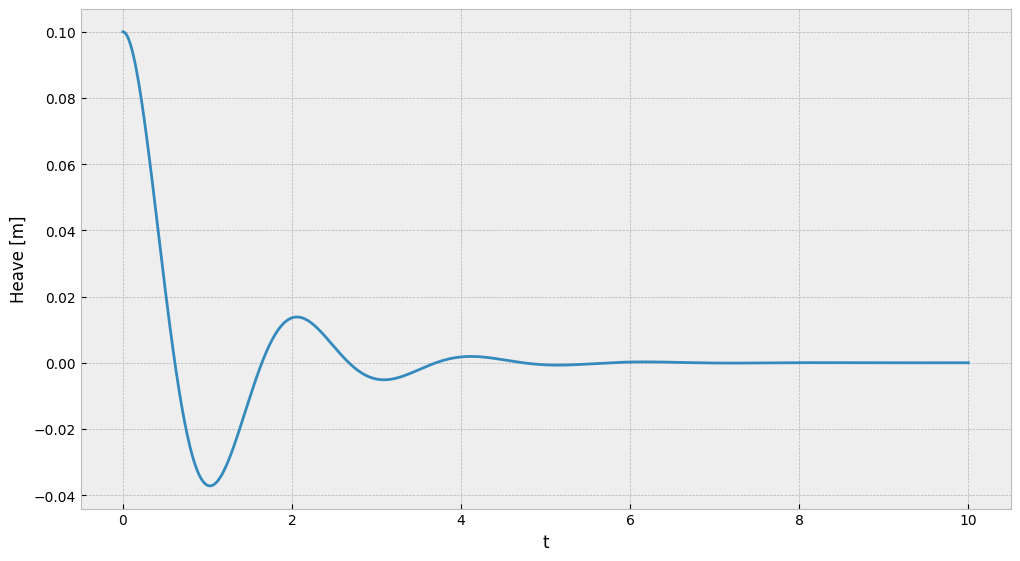

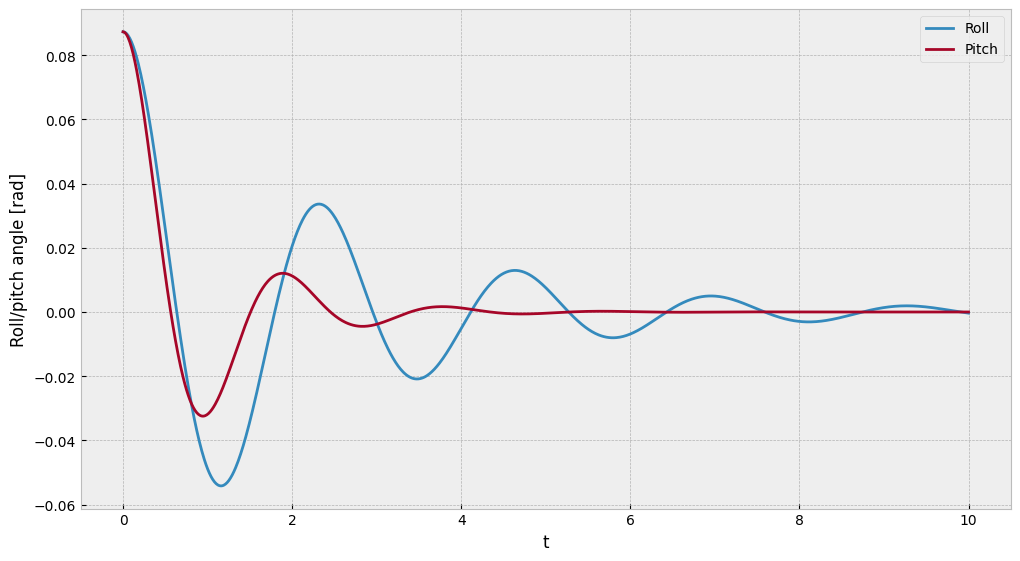

Simulink rigid body FMU coefficients:
m	 16116.7
m_added[3]	 24175.05
I[1]	 49357.39375
I[2]	 145050.3
I_added[1]	 24678.696875
I_added[2]	 0.0
-----------------------------------------------------------------------------------------------
Hull seakeeping FMU coefficients:
heave_damping	 46418.33014
roll_damping	 60895.736907
pitch_damping	 303539.509515
mass	 16116.7
waterplane_area	 24.6
GM_roll	 3.52
GM_pitch	 11.16
-----------------------------------------------------------------------------------------------


In [15]:

added_mass_factors = [0.5, 0.5, 0.0]#Educated guess
inertias = seakeeping.Inertias(ship_dim, added_mass_factors)

#From Zeabuz 1 hydrostatics
GM_roll = 3.52
GM_pitch = 11.16
waterplane_area = 24.6

hydrostatics = seakeeping.Hydrostatics(GM_roll, GM_pitch, waterplane_area)

#Tunable parameters to get desired decay response
damping_ratio_heave = 0.3
damping_ratio_roll = 0.15
damping_ratio_pitch = 0.3
damping_ratios = [damping_ratio_heave, damping_ratio_roll, damping_ratio_pitch]

seakeeping_model = seakeeping.Seakeeping(ship_dim, hydrostatics, inertias, damping_ratios)

seakeeping_model.print_seakeeping_data()
seakeeping_model.plot_decay_response()
simulink_rigid_body_coeffs = seakeeping_model.generate_coeffs_simulink_rigid_body()
hull_seakeeping_model_coeffs = seakeeping_model.generate_coeffs_cpp_hull_seakeeping()

print('Simulink rigid body FMU coefficients:')
vessel_model_common.print_coeffs(simulink_rigid_body_coeffs)
print('-----------------------------------------------------------------------------------------------')
vessel_model_common.write_osp_coeffs_to_xml(simulink_rigid_body_coeffs, ship_name + '_simulink_rigid_body_coeffs.xml')

print('Hull seakeeping FMU coefficients:')
vessel_model_common.print_coeffs(hull_seakeeping_model_coeffs)
print('-----------------------------------------------------------------------------------------------')
vessel_model_common.write_osp_coeffs_to_xml(hull_seakeeping_model_coeffs, ship_name + '_hull_seakeeping_coeffs.xml')




## Propeller tuning

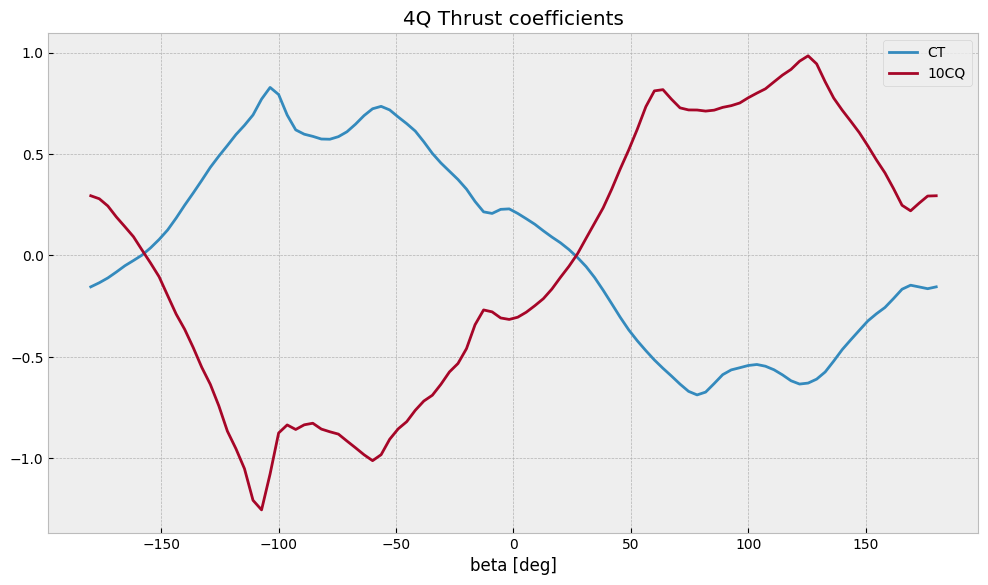

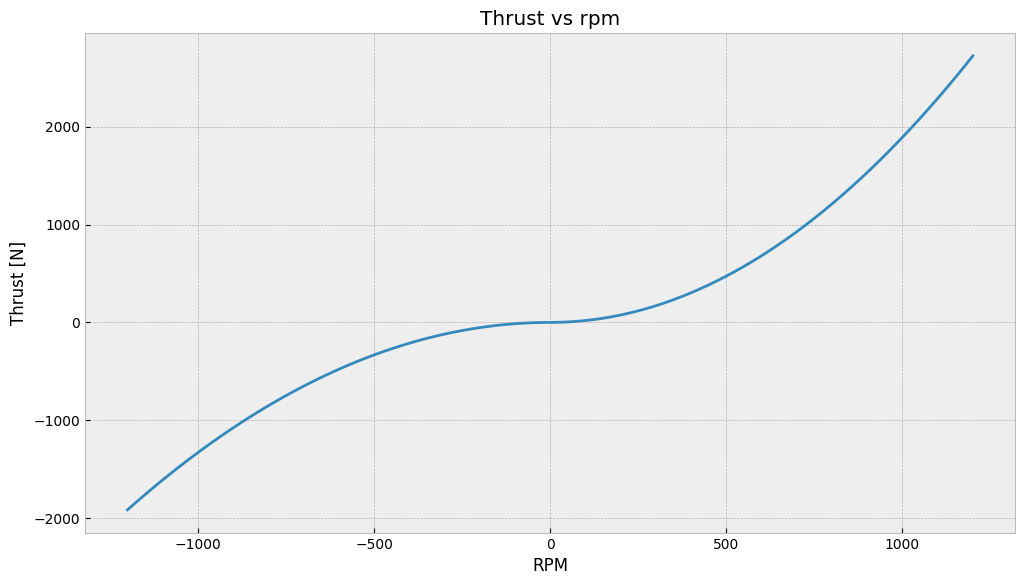

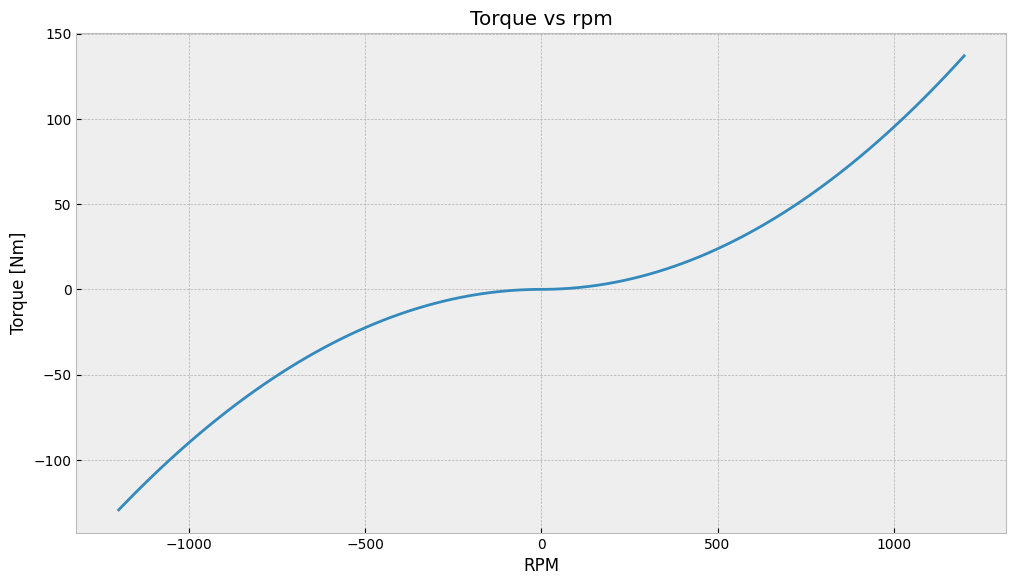

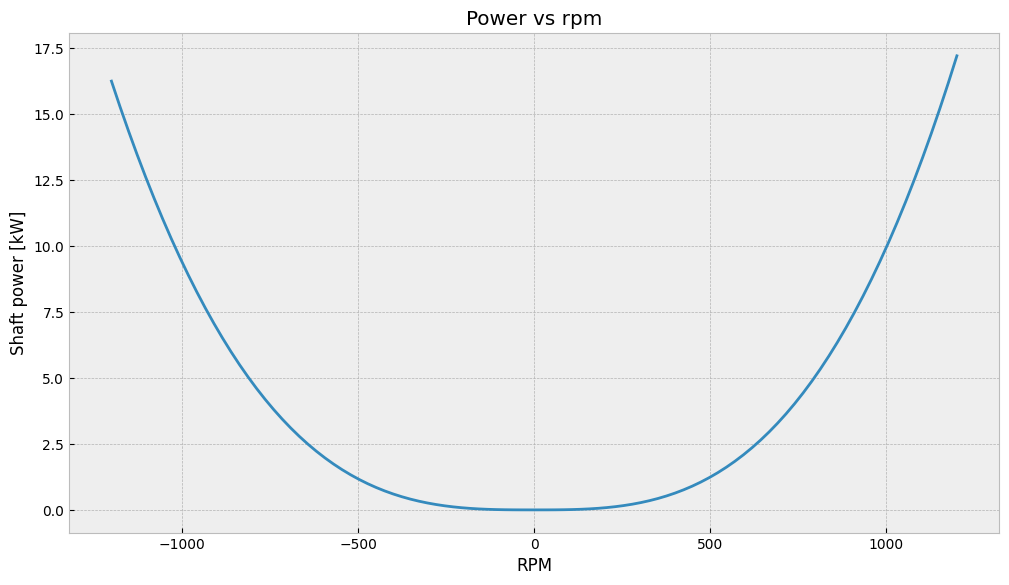

In [16]:
propeller_geometry = 'Wageningen_B4_55_PD1'
propeller_diameter = 0.355

prop = propeller.FourQuadrantPropeller(propeller_geometry, propeller_diameter)

prop.four_quadrant_plot()

#Plot bollard pull thrsut
speed = 0.0
min_rpm = -1200
max_rpm = 1200
rpm_list = np.linspace(min_rpm, max_rpm, 100)
prop.plot_thrust_torque_power_vs_rpm(rpm_list, speed)
